In [1]:
import pandas as pd
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2023-04-18 01:49:35.902848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 01:49:36.728955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Read csv

In [2]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [3]:
lines = pd.read_csv("./nlp_data.csv")

context_raw = []
target_raw = []
for i in lines.index:
    context_raw.append(" ".join(str(v) for v in lines.iloc[i].values[1:-1]))
    target_raw.append(lines.iloc[i].values[-1])

context_raw = np.array(context_raw)
target_raw = np.array(target_raw)

print(context_raw)
print(target_raw)

print(len(context_raw[0]))
print(len(target_raw[0]))

['7 October 2023 15 Ema high 10.143 dewpoint nan positive contribution nan 0.0 nan 0.0 2.0 nan'
 '8 June 2023 16 Ana medium 2.8 temperature nan negative impact nan 2.0 1.0 nan nan 0.0'
 '27 February 2023 14 Ema high 9.429 dewpoint temperature positive contribution positive contribution nan 0.0 0.0 nan 0.0'
 '28 November 2023 15 Ana very high 13.857 solar radiation nan significant positive contribution nan 1.0 0.0 0.0 0.0 nan'
 '6 April 2024 6 Diana low 3.429 solar radiation hourly precipitation negative impact significant negative impact 2.0 nan 0.0 nan nan'
 '26 October 2023 14 Ana medium 3.733 hourly precipitation nan negative impact nan nan 2.0 nan 2.0 nan'
 '14 April 2024 11 Carlos very high 3.28 solar radiation temperature significant positive contribution positive contribution 0.0 0.0 nan nan 0.0'
 '14 June 2023 14 Ema high 2.48 dewpoint solar radiation positive contribution positive contribution nan nan 0.0 nan 0.0'
 '1 January 2024 15 Ema high 2.72 temperature nan positive cont

In [4]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

2023-04-18 01:49:37.947987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 01:49:37.982482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 01:49:37.982841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'27 February 2024 14 Diana medium 8.286 hourly precipitation temperature negative impact negative impact 1.0 2.0 0.0 nan 0.0'
 b'17 February 2023 16 Lu\xc3\xads very high 5.4 temperature solar radiation positive contribution significant positive contribution 0.0 nan nan nan 0.0'
 b'3 November 2023 20 Diana very low 0.6 hourly precipitation nan significant negative impact nan 1.0 2.0 2.0 2.0 2.0'
 b'1 January 2024 9 Pedro very low 2.286 solar radiation daily rain significant negative impact significant negative impact nan nan 2.0 nan 2.0'
 b'12 August 2023 12 Ana very high 5.667 temperature nan positive contribution nan 0.0 nan 1.0 0.0 0.0'], shape=(5,), dtype=string)

tf.Tensor(
[b"Dear Diana,\n\nWe hope this message finds you well. We wanted to update you on the predicted solar power generated by your solar panels on February 27th, 2024 at 2 pm. Based on our analysis, we predict that you will generate approximately 8.286 kilo Watts of power during this time. \n\nHowever, 

2023-04-18 01:49:39.050408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [209]
	 [[{{node Placeholder/_1}}]]
2023-04-18 01:49:39.050926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [209]
	 [[{{node Placeholder/_0}}]]


In [6]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿0-9]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

#### Context text vectorization

In [7]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
print(len(context_text_processor.get_vocabulary()))
print(context_text_processor.get_vocabulary())

2023-04-18 01:49:39.207181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [209]
	 [[{{node Placeholder/_1}}]]
2023-04-18 01:49:39.207417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [209]
	 [[{{node Placeholder/_1}}]]


114
['', '[UNK]', '0', '.', 'nan', '2', '[START]', '[END]', 'negative', 'impact', '1', 'positive', 'contribution', '2023', '2024', 'significant', 'solar', 'radiation', 'high', 'very', 'temperature', 'low', 'medium', 'precipitation', 'hourly', '6', '4', '3', 'rain', 'daily', 'dewpoint', '12', '9', '8', '14', '10', '20', '18', 'february', '7', '15', 'september', '19', '17', '13', 'rafael', 'pedro', 'may', 'luis', 'franciso', 'diana', '11', 'april', 'carlos', '5', '16', 'leticia', 'june', 'july', 'january', 'august', 'ana', 'tomas', 'october', 'november', 'december', 'humidity', 'ema', 'march', '26', 'ricardo', 'constantino', '286', '857', '429', '28', '25', '143', '714', '22', '27', '267', '133', '56', '333', '29', '24', '23', '067', '92', '867', '76', '733', '68', '667', '30', '21', '571', '533', '36', '31', '04', '933', '88', '64', '48', '44', '32', '96', '84', '72', '52', '467', '08']


#### Target text vectorization

In [8]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
print(len(target_text_processor.get_vocabulary()))
print(target_text_processor.get_vocabulary())

2023-04-18 01:49:39.362991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [209]
	 [[{{node Placeholder/_0}}]]
2023-04-18 01:49:39.363429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [209]
	 [[{{node Placeholder/_1}}]]


1118
['', '[UNK]', ',', '.', 'the', 'power', 'to', 'you', 'solar', 'your', 'we', 'this', 'generated', 'that', 'and', 'on', 'of', 'at', 'predicted', 'a', 'will', 'is', 'as', 'for', 'panels', 'have', 'exceed', 'any', 'be', 'heater', 'with', 'generation', 'tenergito', 'time', '[START]', '[END]', 'hope', 'please', 'kilo', 'watts', 'during', 'us', 'use', 'best', 'it', 'or', 'dear', 'are', 'regards', 'appliances', 'if', 'report', 'value', 'questions', 'our', 'washing', 'due', 'machine', 'concerns', 'not', 'well', 'energy', 'may', 'dishwasher', 'impact', 'finds', 'water', 'i', 'high', 'can', 'air', 'conditioner', 'however', '2024', '2023', 'in', 'based', 'radiation', 'from', 'negative', 'message', 'hesitate', 'recommend', 'inform', 'provide', 'predictions', 'wanted', 'without', 'using', 'prediction', 'do', 'thank', 'positive', 'usage', 'temperature', 'by', 'oclock', 'information', 'contact', 'low', 'further', 'about', 'definitely', 'might', '0', 'expected', 'contribution', 'generate', 'amount

In [9]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[6, 80, 38, 14, 34, 50, 22, 33, 3, 72, 24, 23, 20, 8, 9, 8, 9, 10, 3, 2, 5,
  3, 2, 2, 3, 2, 4, 2, 3, 2, 7]                                             ,
 [6, 43, 38, 13, 55, 48, 19, 18, 54, 3, 26, 20, 16, 17, 11, 12, 15, 11, 12,
  2, 3, 2, 4, 4, 4, 2, 3, 2, 7]                                            ,
 [6, 27, 64, 13, 36, 50, 19, 21, 2, 3, 25, 24, 23, 4, 15, 8, 9, 4, 10, 3, 2,
  5, 3, 2, 5, 3, 2, 5, 3, 2, 5, 3, 2, 7]                                    ]>

In [10]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 27 february 2024 14 diana medium 8 . 286 hourly precipitation temperature negative impact negative impact 1 . 0 2 . 0 0 . 0 nan 0 . 0 [END]'

Text(0.5, 1.0, 'Mask')

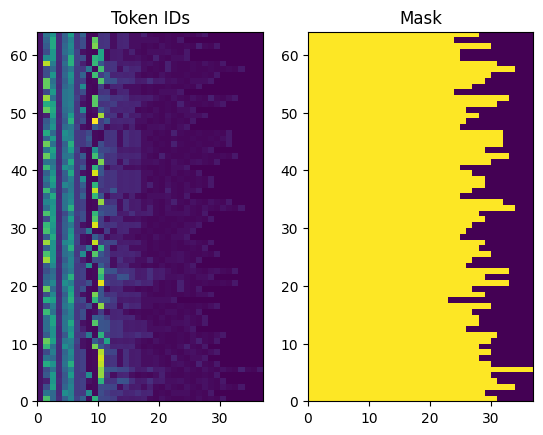

In [11]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 6 25 64 13 32 62 18 26  3 81]

[ 34  46 270   2  67  36  11 360  65   7]
[ 46 270   2  67  36  11 360  65   7  60]


2023-04-18 01:49:40.264662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype resource
	 [[{{node Placeholder/_11}}]]
2023-04-18 01:49:40.265798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype resource
	 [[{{node Placeholder/_15}}]]


In [14]:
UNITS = 2**9

#### Define Encoder


In [15]:
class Encoder(tf.keras.layers.Layer):
  def get_config(self):
    config = {
        'text_processor': self.text_processor,
        'units': self.units
    }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))
  
  def __init__(self, text_processor, vocab_size, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = vocab_size
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))
      
  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

def convert_input(encoder, texts):
  texts = tf.convert_to_tensor(texts)
  if len(texts.shape) == 0:
    texts = tf.convert_to_tensor(texts)[tf.newaxis]
  context = encoder.text_processor(texts)
  context = context.to_tensor()
  context = encoder(context)
  return context

In [16]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, context_text_processor.vocabulary_size(), UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

2023-04-18 01:49:41.657009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


Context tokens, shape (batch, s): (64, 34)
Encoder output, shape (batch, s, units): (64, 34, 512)


#### CrossAttention

In [17]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 34, 512)
Target sequence, shape (batch, t, units): (64, 278, 512)
Attention result, shape (batch, t, units): (64, 278, 512)
Attention weights, shape (batch, t, s):    (64, 278, 34)


In [19]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 0.99999994, 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 1.        , 1.0000001 , 0.99999994, 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.00000

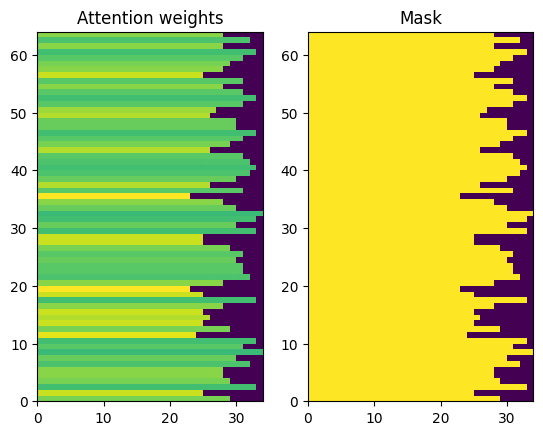

In [20]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


#### Define Decoder

In [21]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def get_config(self):
    config = {
            'text_processor': self.text_processor,
            'vocab': self.vocab,
            'vocab_size' : self.vocab_size,
            'units': self.units
        }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))
  
  def __init__(self, text_processor, vocab, vocab_size, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab = vocab
    self.vocab_size = vocab_size
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=self.vocab,
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=self.vocab,
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
    
  def call(self, context, x, state=None, return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
      return logits, state
    else:
      return logits

  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
      context, next_token,
      state = state,
      return_state=True) 
    
    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    
    return next_token, done, state

In [22]:
decoder = Decoder(target_text_processor, target_text_processor.get_vocabulary(), target_text_processor.vocabulary_size(), UNITS)

In [23]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 34, 512)
input target tokens shape: (batch, t) (64, 278)
logits shape shape: (batch, target_vocabulary_size) (64, 278, 1118)


In [24]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'advantage fully our check even exceptionally token timely [START] disruptions',
       b'measuring 2023subject such know risk you maintain change 64 range',
       b'spirits 1300dear models than generated updating air anticipated machine 27th'],
      dtype=object)

#### Define Translator

In [25]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def get_config(self):
    config = {
            'units': self.units,
            'context_text_processor': self.context_text_processor,
            'context_vocab_size' : self.context_vocab_size,
            'target_text_processor': self.target_text_processor,
            'target_vocab': self.target_vocab,
            'target_vocab_size': self.target_vocab_size
        }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))
  
  @classmethod
  def from_config(cls, config):
      return cls(**config)

  def __init__(self, units,
               context_text_processor, context_vocab_size,
               target_text_processor, target_vocab, target_vocab_size):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, context_vocab_size, units)
    decoder = Decoder(target_text_processor, target_vocab, target_vocab_size, units)

    self.encoder = encoder
    self.decoder = decoder
    self.units = units
    self.context_text_processor = context_text_processor
    self.context_vocab_size = context_vocab_size
    self.target_text_processor = target_text_processor
    self.target_vocab = target_vocab
    self.target_vocab_size = target_vocab_size

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

  def translate(self, texts, *, max_length=700, temperature=0.0):
    # Process the input texts
    context = convert_input(self.encoder,texts)
    #batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)
          
      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)
      
      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [26]:
model = Translator(UNITS, context_text_processor, context_text_processor.vocabulary_size(), target_text_processor, target_text_processor.get_vocabulary(), target_text_processor.vocabulary_size())
logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 34)
Target tokens, shape: (batch, t) (64, 278)
logits, shape: (batch, t, target_vocabulary_size) (64, 278, 1118)


In [27]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [29]:
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])
history = model.fit(train_ds.repeat(), epochs=10, steps_per_epoch = 100,
    validation_data=val_ds.repeat(), validation_steps = 20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10


2023-04-18 01:51:52.936891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64
	 [[{{node Placeholder/_12}}]]
2023-04-18 01:51:52.938125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype int64
	 [[{{node Placeholder/_18}}]]
2023-04-18 01:51:56.385942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]

100/100 [==============================] - 44s 317ms/step - loss: 0.0691 - masked_acc: 0.9880 - masked_loss: 0.0678
Epoch 2/10
100/100 [==============================] - 27s 275ms/step - loss: 0.0090 - masked_acc: 1.0000 - masked_loss: 0.0090
Epoch 3/10
100/100 [==============================] - 27s 266ms/step - loss: 0.0042 - masked_acc: 1.0000 - masked_loss: 0.0042
Epoch 4/10
100/100 [==============================] - 25s 251ms/step - loss: 0.0024 - masked_acc: 1.0000 - masked_loss: 0.0024
Epoch 5/10
100/100 [==============================] - 26s 256ms/step - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016
Epoch 6/10
100/100 [==============================] - 24s 244ms/step - loss: 0.1817 - masked_acc: 0.9551 - masked_loss: 0.1810
Epoch 7/10
100/100 [==============================] - 25s 253ms/step - loss: 0.0462 - masked_acc: 0.9902 - masked_loss: 0.0454
Epoch 8/10
100/100 [==============================] - 24s 242ms/step - loss: 0.0066 - masked_acc: 1.0000 - masked_loss: 0.

In [30]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()
{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.0192966, 'expected_acc': 0.0008944543828264759}

In [42]:
result = model.translate(['8 March 2024 13 rafael medium 8.0 hourly precipitation temperature negative impact negative impact 2.0 0.0 2.0 0.0 1.0'])
print(len(result[0].numpy().decode()))
result[0].numpy().decode()

750


'report for client rafael solar power predictions for february 13rd 2024 at 8 oclock . according to our analysis , the solar power generated will be very low , at approximately 0 . 16 kilo watts . unfortunately , this is slightly less than we originally anticipated due to the impact of predicted temperatures . we would like to advise that during this time period , your air conditioner and washing machine may exceed the generated power , so it is recommended to use it outside of this time frame . we hope that this information is useful to you and helps you plan your energy usage accordingly . if you have any questions or concerns , please do not hesitate to contact me . thank you for your continued partnership with us . sincerely , tenergito '

In [32]:
model.save("nlp_model")

2023-04-18 01:56:55.669741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 01:56:55.671837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 01:56:55.672960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: nlp_model/assets


INFO:tensorflow:Assets written to: nlp_model/assets


In [33]:
load_model = tf.keras.models.load_model("nlp_model", custom_objects={'Translator': Translator, 'tf_lower_and_split_punct': tf_lower_and_split_punct,'masked_acc': masked_acc, 'masked_loss': masked_loss})

2023-04-18 01:57:20.821332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-04-18 01:57:20.823168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-04-18 01:57:20.823372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [34]:
load_model

In [35]:
model.evaluate(val_ds, steps=100, return_dict=True)

  1/100 [..............................] - ETA: 5:08 - loss: 3.9194 - masked_acc: 0.5606 - masked_loss: 3.9194WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 100 batches). You may need to use the repeat() function when building your dataset.


100/100 [==============================] - 3s 233us/step - loss: 3.9194 - masked_acc: 0.5606 - masked_loss: 3.9194


{'loss': 3.9193601608276367,
 'masked_acc': 0.5605592131614685,
 'masked_loss': 3.9193601608276367}

In [36]:
load_model.evaluate(val_ds, steps=100, return_dict=True)

  1/100 [..............................] - ETA: 9:46 - loss: 4.1182 - masked_acc: 0.5443 - masked_loss: 4.1182WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 100 batches). You may need to use the repeat() function when building your dataset.


100/100 [==============================] - 6s 282us/step - loss: 4.1182 - masked_acc: 0.5443 - masked_loss: 4.1182


{'loss': 4.118222236633301,
 'masked_acc': 0.5442935824394226,
 'masked_loss': 4.118222236633301}

In [44]:
result = load_model.translate(['7 February 2024 13 ema medium 8.0 hourly precipitation temperature positive impact negative impact 2.0 0.0 2.0 0.0 1.0'])

print(len(result[0].numpy().decode()))
result[0].numpy().decode()

461


'dear rafael , i hope this message finds you well . as your solar power provider , i wanted to provide you with some information regarding the predicted solar power generation from your solar panels on august 5th , 2024 , at 600 am . based on the data we have collected to have a negative impact prediction report for choosing solar power . as always , if you have any further questions or concerns , please do not hesitate to contact us . sincerely , tenergito '